Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0095
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0012
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0012
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0011
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 8.0483e-04
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 7.3688e-04
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 7.8002e-04
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 6.8332e-04
Epoch 9/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 6.1513e-04
Epoch 10/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 5.8933e-04
Epoch 11/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 5.9363e-04
Epoch 12/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 5.3667e-04
Epoch 13/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 5.2668e-04
Epoch 14/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 4.6134e-04
Epoch 15/50
65/65 ━━━━━━━━━━━━━

c:\Users\pc\Desktop\10 Academy\Week 11\gmf-time-series-portfolio\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\pc\Desktop\10 Academy\Week 11\gmf-time-series-portfolio\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\pc\Desktop\10 Academy\Week 11\gmf-time-series-portfolio\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\pc\Desktop\10 Academy\Week 11\gmf-time-series-portfolio\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible star

LSTM → RMSE: 106.44, MAE: 9.86, MAPE: 3.63%
ARIMA → RMSE: 77.93, MAE: 62.98, MAPE: 24.11%
Best ARIMA order: (1, 1, 3)


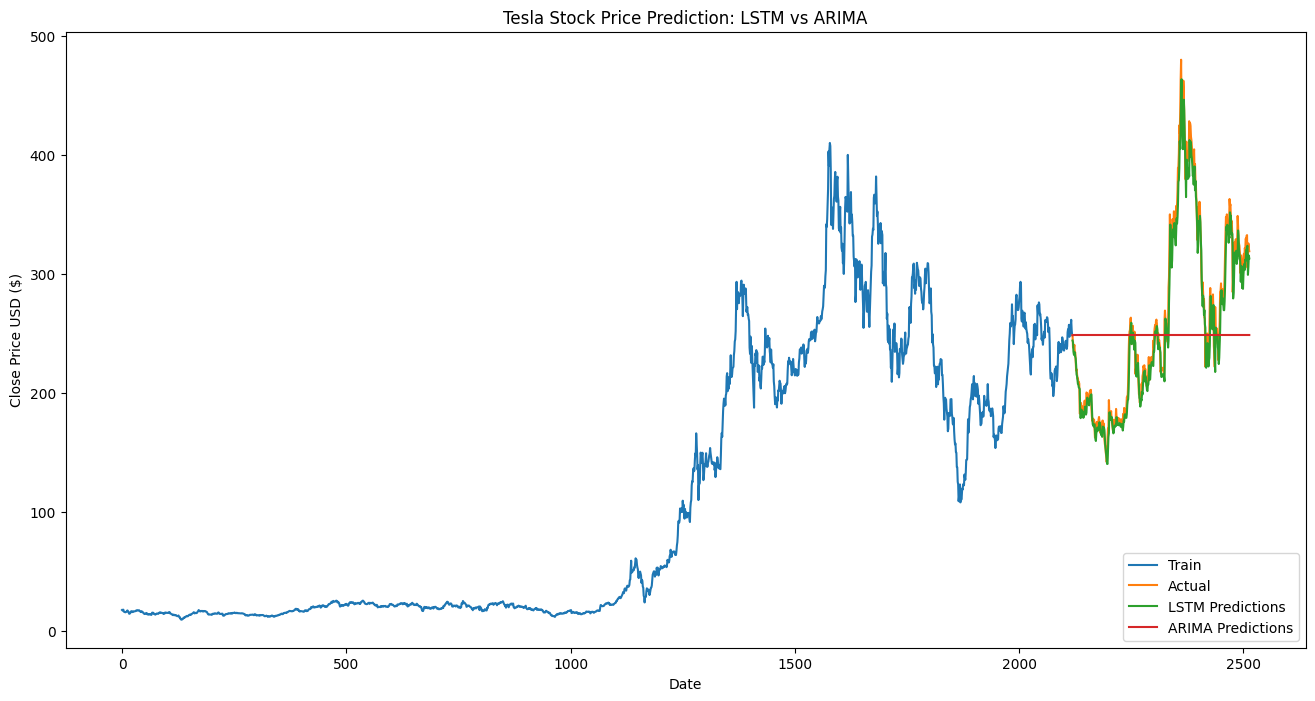

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
from keras.callbacks import EarlyStopping
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import itertools

# -------------------------------
# 1. Load Tesla dataset
# -------------------------------
df = pd.read_csv("../data/TSLA.csv", parse_dates=["Date"])
df = df.sort_values('Date')
data = df.filter(['Close'])
dataset = data.values

# -------------------------------
# 2. Chronological train/test split
# -------------------------------
train_df = df[df['Date'] < '2024-01-01']
test_df = df[df['Date'] >= '2024-01-01']

train_data = train_df['Close'].values
test_data = test_df['Close'].values

# -------------------------------
# 3. Scale data for LSTM
# -------------------------------
scaler = MinMaxScaler(feature_range=(0,1))
scaled_train = scaler.fit_transform(train_data.reshape(-1,1))
scaled_test = scaler.transform(np.concatenate((train_data[-60:], test_data)).reshape(-1,1))

# -------------------------------
# 4. Function to create sequences
# -------------------------------
def create_sequences(data, seq_length=60):
    x = []
    y = []
    for i in range(seq_length, len(data)):
        x.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

x_train, y_train = create_sequences(scaled_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

x_test, y_test = create_sequences(scaled_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test_orig = test_data  # for inverse comparison

# -------------------------------
# 5. Build and train LSTM model
# -------------------------------
model = Sequential()
model.add(Input(shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
es = EarlyStopping(monitor='loss', patience=5)
model.fit(x_train, y_train, epochs=50, batch_size=32, callbacks=[es])

# LSTM predictions
lstm_predictions = model.predict(x_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)
rmse_lstm = math.sqrt(np.mean((lstm_predictions - y_test_orig)**2))
mae_lstm = mean_absolute_error(y_test_orig, lstm_predictions)
mape_lstm = mean_absolute_percentage_error(y_test_orig, lstm_predictions)

# -------------------------------
# 6. ARIMA Grid Search
# -------------------------------
p = range(0, 6)
d = range(0, 2)
q = range(0, 6)

best_rmse = float('inf')
best_order = None

for order in itertools.product(p,d,q):
    try:
        model_arima = ARIMA(train_data, order=order)
        result = model_arima.fit()
        forecast = result.forecast(steps=len(test_data))
        rmse = math.sqrt(mean_squared_error(test_data, forecast))
        if rmse < best_rmse:
            best_rmse = rmse
            best_order = order
            best_forecast = forecast
    except:
        continue

rmse_arima = best_rmse
arima_forecast = best_forecast
mae_arima = mean_absolute_error(test_data, arima_forecast)
mape_arima = mean_absolute_percentage_error(test_data, arima_forecast)

print("LSTM → RMSE: {:.2f}, MAE: {:.2f}, MAPE: {:.2%}".format(rmse_lstm, mae_lstm, mape_lstm))
print("ARIMA → RMSE: {:.2f}, MAE: {:.2f}, MAPE: {:.2%}".format(rmse_arima, mae_arima, mape_arima))
print("Best ARIMA order:", best_order)

# -------------------------------
# 7. Plot predictions
# -------------------------------
valid = test_df.copy()
valid['LSTM_Predictions'] = lstm_predictions
valid['ARIMA_Predictions'] = arima_forecast

plt.figure(figsize=(16,8))
plt.plot(train_df['Close'], label='Train')
plt.plot(valid['Close'], label='Actual')
plt.plot(valid['LSTM_Predictions'], label='LSTM Predictions')
plt.plot(valid['ARIMA_Predictions'], label='ARIMA Predictions')
plt.title('Tesla Stock Price Prediction: LSTM vs ARIMA')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.legend(loc='lower right')
plt.show()

import pickle

# Save LSTM model
model.save("models/lstm_model.h5")

# Save the best ARIMA model (fitted result)
with open("models/arima_model.pkl", "wb") as f:
    pickle.dump(result, f)  # 'result' is the last successful fit, or you can store the best one


Index(['Ticker', 'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Daily Return', 'Volatility'],
      dtype='object')